In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/主焦煤价格-临汾.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['主焦煤价格/临汾'].last_valid_index()                        

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()


,主焦煤价格/临汾,主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存,焦煤港口库存,焦煤煤矿库存/523家样本矿山
2025-12-01,NaN,NaN,NaN,NaN
2025-12-02,NaN,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN,NaN
2025-12-04,NaN,NaN,NaN,NaN
2025-12-05,NaN,NaN,NaN,NaN


In [5]:
file_path1 = os.path.expanduser("eta/主焦煤价格-临汾拟合残差-焦煤煤矿+港口库存_合并数据.xlsx") 
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.drop(columns=['真实值'])
sheet1 = sheet1.dropna()

sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1.tail()

,Date,预测值
4,2025-11-28,-77.1425
3,2025-12-01,-76.5792
2,2025-12-02,-76.8359
1,2025-12-03,-74.8229
0,2025-12-04,-72.4147


In [6]:
file_path2 = os.path.expanduser("eta/焦煤港口库存_合并数据.xlsx") 
sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2 = sheet2.drop(columns=['真实值'])
sheet2 = sheet2.dropna()

sheet2 = sheet2.sort_values('Date', ascending=True)
sheet2.head()

,Date,预测值
19,2025-11-10,327.2
18,2025-11-11,327.6
17,2025-11-12,325.3
16,2025-11-13,324.4
15,2025-11-14,323.0


In [7]:
file_path3 = os.path.expanduser("eta/焦煤煤矿库存_合并数据.xlsx") 
sheet3 = pd.ExcelFile(file_path3).parse('Sheet1')
sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
sheet3 = sheet3.drop(columns=['真实值'])
sheet3 = sheet3.dropna()

sheet3 = sheet3.sort_values('Date', ascending=True)
sheet3.head()

,Date,预测值
19,2025-11-10,389.2
18,2025-11-11,417.3
17,2025-11-12,419.1
16,2025-11-13,416.2
15,2025-11-14,432.0


In [8]:
sheet.columns

Index(['主焦煤价格/临汾', '主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存', '焦煤港口库存', '焦煤煤矿库存/523家样本矿山'], dtype='object')

In [9]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存'] = sheet_daily['主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['焦煤港口库存'] = sheet_daily['焦煤港口库存'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# sheet 3
sheet_daily = pd.merge(
    sheet_daily,
    sheet3[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['焦煤煤矿库存/523家样本矿山'] = sheet_daily['焦煤煤矿库存/523家样本矿山'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]
sheet_daily.tail(10)

,Date,主焦煤价格/临汾,主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存,焦煤港口库存,焦煤煤矿库存/523家样本矿山
4100,2025-11-24,NaN,-71.0577,298.7,465.9
4101,2025-11-25,NaN,-70.4804,297.4,475.7
4102,2025-11-26,NaN,-72.7173,298.4,475.9
4103,2025-11-27,NaN,-72.2560,299.4,475.2
4104,2025-11-28,NaN,-77.1425,300.3,473.1
4105,2025-12-01,NaN,-76.5792,297.6,468.4
4106,2025-12-02,NaN,-76.8359,297.6,473.6
4107,2025-12-03,NaN,-74.8229,319.5,473.1
4108,2025-12-04,NaN,-72.4147,319.6,441.9
4109,2025-12-05,NaN,NaN,285.9,420.2


In [10]:
# 添加新列 主焦煤价格/临汾_预测
sheet_daily['主焦煤价格/临汾_预测'] = -1.7633*(sheet_daily['焦煤港口库存']+sheet_daily['焦煤煤矿库存/523家样本矿山']) + 2999.1910 + 0.8*sheet_daily['主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存'] 
sheet_daily.tail(10)


,Date,主焦煤价格/临汾,主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存,焦煤港口库存,焦煤煤矿库存/523家样本矿山,主焦煤价格/临汾_预测
4100,2025-11-24,NaN,-71.0577,298.7,465.9,1594.12566
4101,2025-11-25,NaN,-70.4804,297.4,475.7,1579.59945
4102,2025-11-26,NaN,-72.7173,298.4,475.9,1575.69397
4103,2025-11-27,NaN,-72.2560,299.4,475.2,1575.53402
4104,2025-11-28,NaN,-77.1425,300.3,473.1,1573.74078
4105,2025-12-01,NaN,-76.5792,297.6,468.4,1587.23984
4106,2025-12-02,NaN,-76.8359,297.6,473.6,1577.86532
4107,2025-12-03,NaN,-74.8229,319.5,473.1,1541.74110
4108,2025-12-04,NaN,-72.4147,319.6,441.9,1598.50629
4109,2025-12-05,NaN,NaN,285.9,420.2,NaN


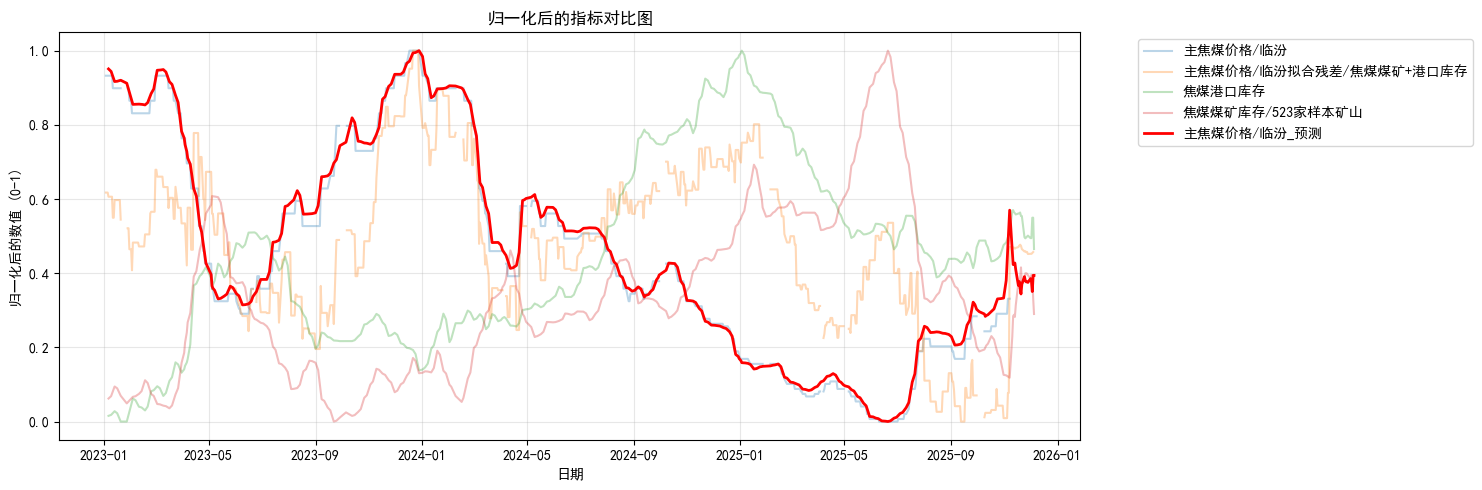

In [11]:
# 对数据进行归一化处理
from sklearn.preprocessing import MinMaxScaler

# 创建一个新的DataFrame来存储归一化后的数据
normalized_df = sheet_daily.copy()

# 对每一列进行归一化处理(除了Date列)
scaler = MinMaxScaler()
columns_to_normalize = [col for col in sheet_daily.columns if col != 'Date']
normalized_df[columns_to_normalize] = scaler.fit_transform(sheet_daily[columns_to_normalize])
# 对这三列进行线性填充
cols_to_fill = ['焦煤港口库存', '焦煤煤矿库存/523家样本矿山', '主焦煤价格/临汾_预测']
normalized_df[cols_to_fill] = normalized_df[cols_to_fill].interpolate(method='linear')

# 绘制归一化后的数据
plt.figure(figsize=(15, 5))

# 设置透明度
alpha_others = 0.3  
alpha_main = 1.0    

# 绘制每个指标
for col in normalized_df.columns:
    if col != 'Date':  
        if col == '主焦煤价格/临汾_预测':
            plt.plot(normalized_df['Date'], normalized_df[col], 
                    label=col, 
                    color='red', 
                    linewidth=2,
                    alpha=alpha_main)
        else:
            plt.plot(normalized_df['Date'], normalized_df[col], 
                    label=col, 
                    alpha=alpha_others)

plt.title('归一化后的指标对比图')
plt.xlabel('日期')
plt.ylabel('归一化后的数值 (0-1)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [12]:
last_day = sheet_daily['Date'][sheet_daily['主焦煤价格/临汾'].last_valid_index()]    
# 删除没有主焦煤价格/临汾_预测有效值的行
sheet_daily = sheet_daily.dropna(subset=['主焦煤价格/临汾_预测'])

sheet_daily.tail(10)

,Date,主焦煤价格/临汾,主焦煤价格/临汾拟合残差/焦煤煤矿+港口库存,焦煤港口库存,焦煤煤矿库存/523家样本矿山,主焦煤价格/临汾_预测
4099,2025-11-21,NaN,-65.3597,321.3,461.1,1567.29732
4100,2025-11-24,NaN,-71.0577,298.7,465.9,1594.12566
4101,2025-11-25,NaN,-70.4804,297.4,475.7,1579.59945
4102,2025-11-26,NaN,-72.7173,298.4,475.9,1575.69397
4103,2025-11-27,NaN,-72.2560,299.4,475.2,1575.53402
4104,2025-11-28,NaN,-77.1425,300.3,473.1,1573.74078
4105,2025-12-01,NaN,-76.5792,297.6,468.4,1587.23984
4106,2025-12-02,NaN,-76.8359,297.6,473.6,1577.86532
4107,2025-12-03,NaN,-74.8229,319.5,473.1,1541.74110
4108,2025-12-04,NaN,-72.4147,319.6,441.9,1598.50629


---

In [13]:
# 创建历史数据部分
historical = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '主焦煤价格/临汾']]
historical.columns = ['Date', '主焦煤价格/临汾']

# 创建预测数据部分 
forecast = sheet_daily[sheet_daily['Date'] > last_day][['Date', '主焦煤价格/临汾_预测']]
forecast.columns = ['Date', '主焦煤价格/临汾_预测']

# 将预测数据转换为周度频度
forecast = forecast.set_index('Date')
forecast = forecast.resample('W-FRI').mean()  # 按周五为时间点重采样并计算平均值
forecast = forecast.reset_index()



# 获取最后一个有主焦煤价格/临汾值的行
last_price_row = historical.iloc[-1]
last_price_date = pd.to_datetime(last_price_row['Date'])
last_price = last_price_row['主焦煤价格/临汾']
# 创建新行,日期为最后一个有值日期的后一天
new_row = pd.DataFrame({
    'Date': [last_price_date + pd.Timedelta(days=1)],
    '主焦煤价格/临汾': [np.nan],
    '主焦煤价格/临汾_预测': [last_price]
})
# 将新行添加到forecast中
forecast = pd.concat([new_row, forecast])



# 合并历史和预测数据
merged_df_daily = pd.concat([historical, forecast], axis=0, join='outer')

merged_df_daily = merged_df_daily.sort_values('Date').reset_index(drop=True)
merged_df_daily = merged_df_daily.sort_values(by='Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')


merged_df_daily.to_excel('eta/主焦煤价格-临汾_合并数据.xlsx', index=False,float_format='%.6f')



merged_df_daily.head()

,Date,主焦煤价格/临汾,主焦煤价格/临汾_预测
140,2025/12/05,NaN,1576.338137
139,2025/11/28,NaN,1579.738776
138,2025/11/21,NaN,1559.473380
137,2025/11/14,NaN,1644.061550
136,2025/11/08,NaN,1660.000000


In [14]:
# 创建历史数据部分
historical_monthly = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '主焦煤价格/临汾']]
historical_monthly.columns = ['Date', '主焦煤价格/临汾']

# 创建预测数据部分 
forecast_monthly = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-10-01')][['Date', '主焦煤价格/临汾_预测']]
forecast_monthly.columns = ['Date', '主焦煤价格/临汾_预测']

merged_df_monthly = pd.merge(historical_monthly, forecast_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 将数值列保留2位小数
merged_df_monthly['主焦煤价格/临汾'] = merged_df_monthly['主焦煤价格/临汾'].round(2)
merged_df_monthly['主焦煤价格/临汾_预测'] = merged_df_monthly['主焦煤价格/临汾_预测'].round(2)

merged_df_monthly.to_excel('eta/主焦煤价格-临汾_月度数据.xlsx', index=False,float_format= '%.4f')            
merged_df_monthly.head()

,Date,主焦煤价格/临汾,主焦煤价格/临汾_预测
35,2025/12/31,NaN,1576.34
34,2025/11/30,1660.0,1608.93
33,2025/10/31,1570.0,1490.54
32,2025/09/30,1482.5,1410.45
31,2025/08/31,1476.0,1401.47


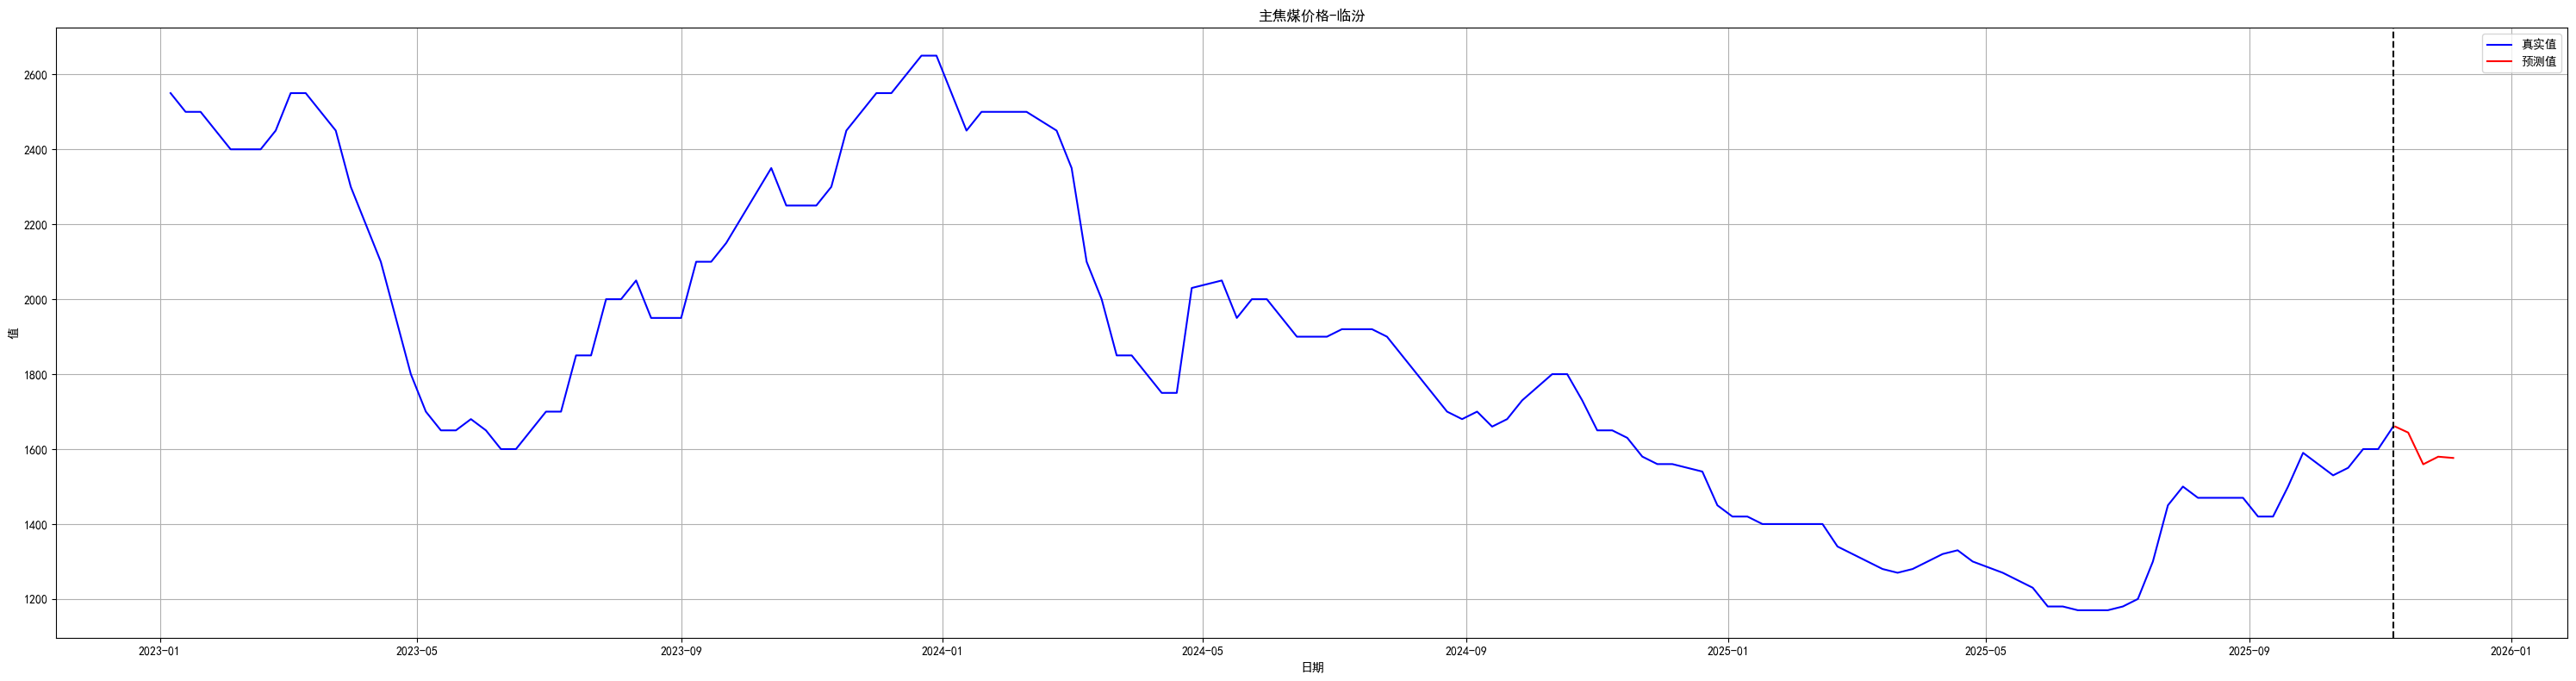

In [15]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_daily_plot = merged_df_daily.copy()
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])

# 绘制真实值曲线(蓝色)
# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['主焦煤价格/临汾'], color='blue', label='真实值')


# 绘制预测值曲线(红色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['主焦煤价格/临汾_预测'], color='red', label='预测值')

avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('主焦煤价格-临汾')
plt.xlabel('日期')
plt.ylabel('值')
plt.grid(True)
plt.tight_layout()
plt.show()

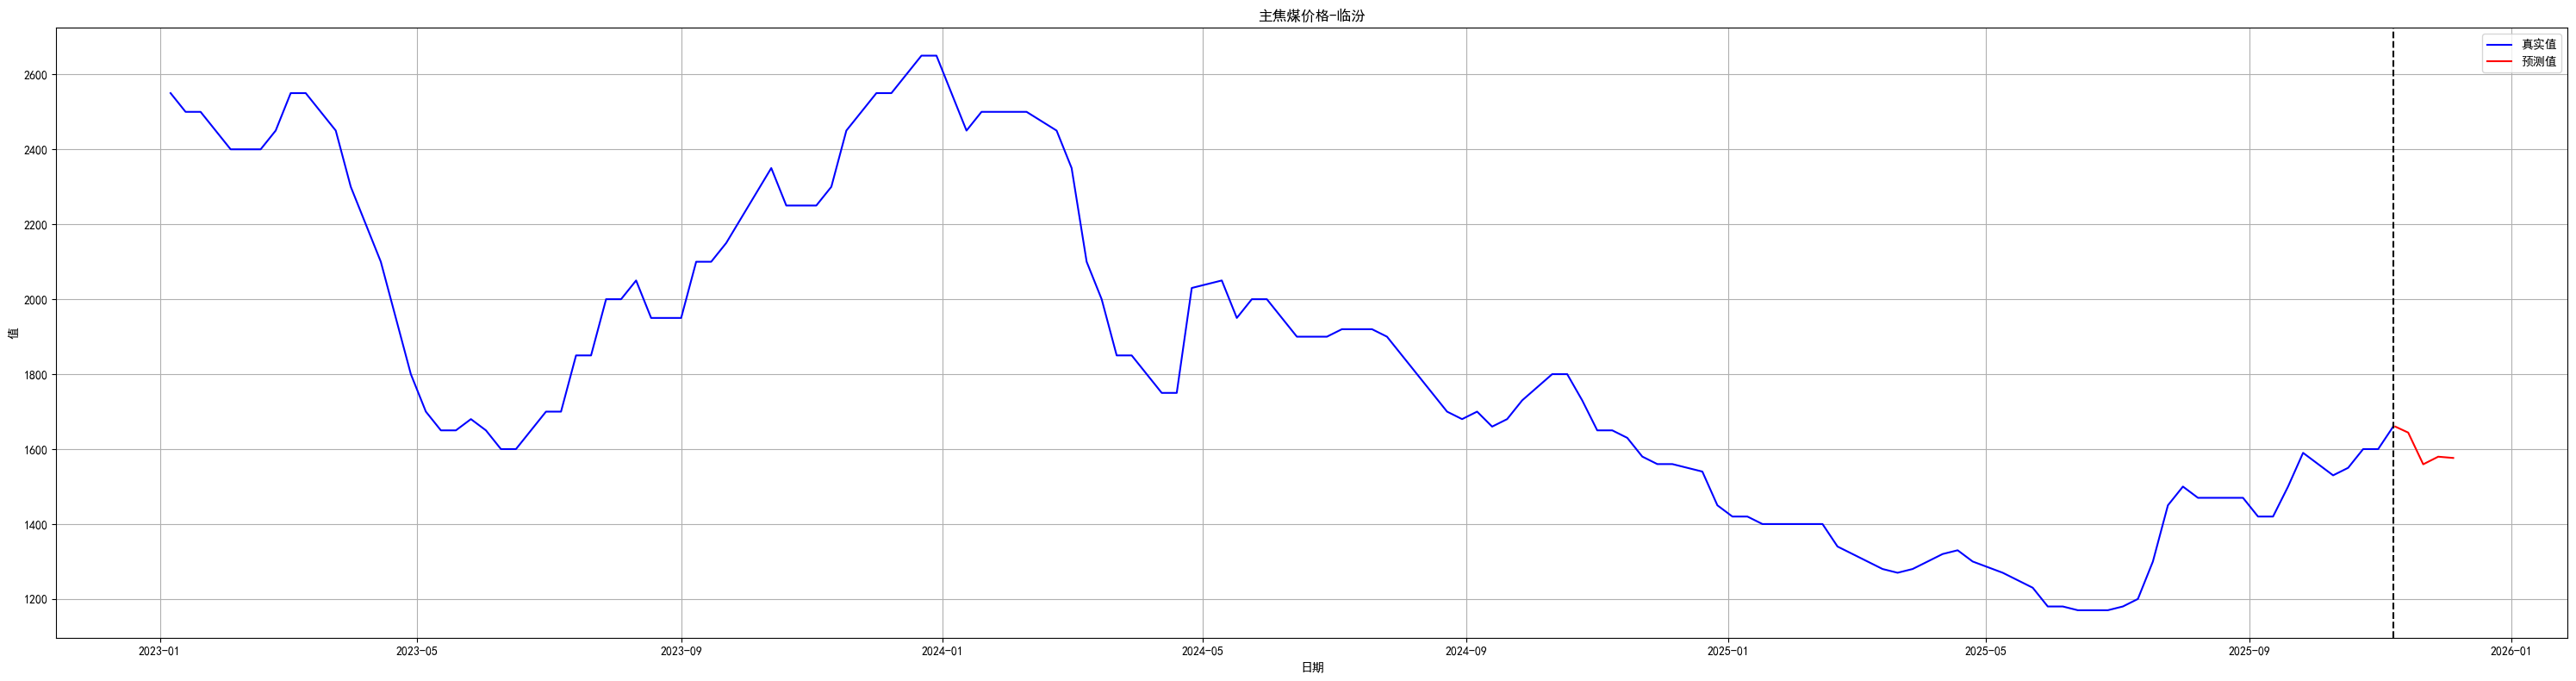

In [16]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_daily_plot = merged_df_daily.copy()
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])

# 绘制真实值曲线(蓝色)
# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['主焦煤价格/临汾'], color='blue', label='真实值')

# 获取最后一个真实值和第一个预测值
last_real_value = merged_df_daily_plot[merged_df_daily_plot['主焦煤价格/临汾'].notna()]['主焦煤价格/临汾'].iloc[0]
first_pred_date = merged_df_daily_plot[merged_df_daily_plot['主焦煤价格/临汾_预测'].notna()]['Date'].iloc[-1]

# 调整预测值的第一个点为最后一个真实值
merged_df_daily_plot.loc[merged_df_daily_plot['Date'] == first_pred_date, '主焦煤价格/临汾_预测'] = last_real_value

# 绘制预测值曲线(红色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['主焦煤价格/临汾_预测'], color='red', label='预测值')

avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('主焦煤价格-临汾')
plt.xlabel('日期')
plt.ylabel('值')
plt.grid(True)
plt.tight_layout()
plt.show()

---

In [17]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.焦煤_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "主焦煤价格/临汾"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [18]:
from Lcel import update_excel_data
file_path = "eta/1.焦煤_数据上传.xlsx"
sheet_name = "详情页"
identifier = "主焦煤价格/临汾"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
